# Disaster Tweets: Exploratory Data Analysis

Greetings! Thanks for checking out my code. 

In this notebook, we will conduct basic EDA to get a better understanding of our dataset and how features are distributed. We will also utilize the NLTK package to parse common words and stopwords.

In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
stopwords = stopwords.words('english')

sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [2]:
train = pd.read_csv("assets/train.csv")
test = pd.read_csv("assets/test.csv")

### Explore the Data

**Data Dictionary**

* id - unique identifier
* keyword - a specific keyword from the tweet
* location - origin of tweet
* text - content of tweet
* target - binary indicator denoting whether the tweet is about a disaster, our value to predict

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


There are 7613 observations in the training data. The test dataset is less than half this size, totalling 3263 rows.

In [4]:
train.shape, test.shape, test.shape[0]/train.shape[0]

((7613, 5), (3263, 4), 0.4286089583606988)

There are a significant number of missing values in the keyword and location columns.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [75]:
null_counts = pd.DataFrame({"Num_Null": train.isnull().sum()})
null_counts["Pct_Null"] = null_counts["Num_Null"] / train.count() * 100
null_counts

,Num_Null,Pct_Null
id,0,0.000000
keyword,61,0.807733
location,2533,49.862205
text,0,0.000000
target,0,0.000000


### Keyword

What are some of the most commonly used keywords?

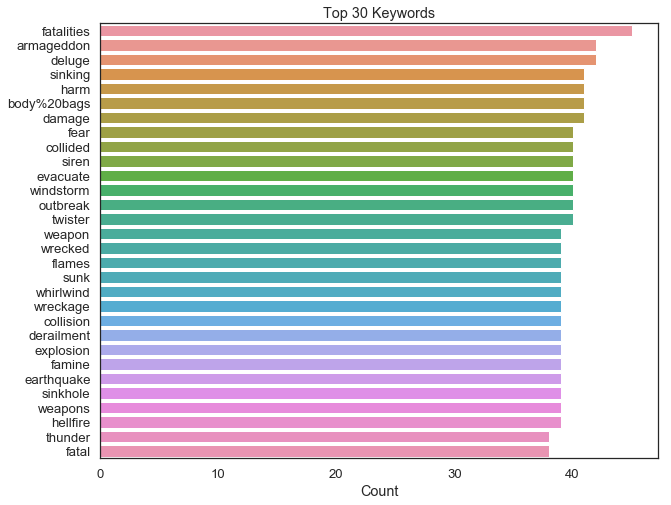

In [135]:
keywords_vc = pd.DataFrame({"Count": train["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:30].index, x=keywords_vc[0:30]["Count"], orient='h')
plt.title("Top 30 Keywords")
plt.show()

Overall, there are 221 different keywords associated with tweets.

In [17]:
len(train["keyword"].value_counts())

221

As we can see when we pull out the top 30 keywords for disaster vs non-disaster tweets, word appearance alone is not sufficient to classify content. For example, "body%20bags" and "armageddon" are the top 1st and 2nd keyword for non-disaster tweets!

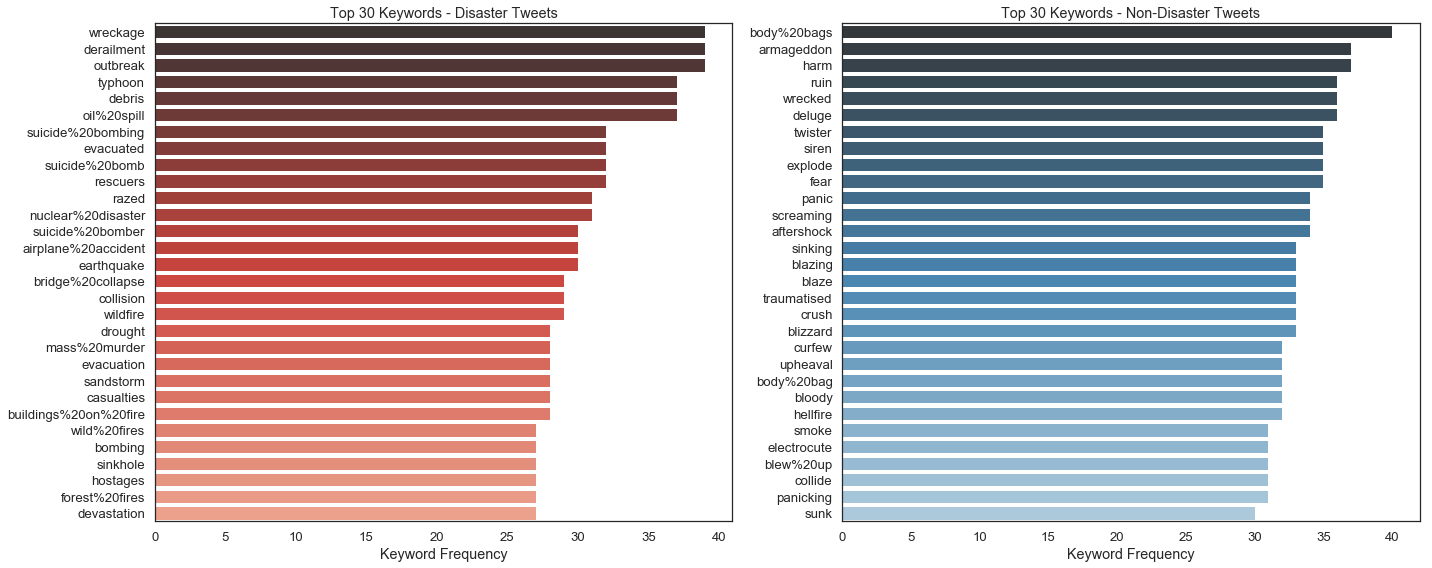

In [50]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:30].index, x=disaster_keywords[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_keywords[0:30].index, x=nondisaster_keywords[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

We can pull out non-disaster tweets containing words that we would expect to be associated with disasters. Clearly, an accurate model will need to take context into account.

In [72]:
armageddon_tweets = train[(train["keyword"].fillna("").str.contains("armageddon")) & (train["target"] == 0)]
print("An example tweet:\n", armageddon_tweets.iloc[10, 3])
armageddon_tweets.head()

An example tweet:
 @ENews Ben Affleck......I know there's a wife/kids and other girls but I can't help it. I've loved him since Armageddon #eonlinechat


,id,keyword,location,text,target
304,446,armageddon,"California, United States",#PBBan (Temporary:300) avYsss @'aRmageddon | D...,0
305,447,armageddon,"California, United States",#PBBan (Temporary:300) Russaky89 @'aRmageddon ...,0
306,448,armageddon,#FLIGHTCITY UK,((OFFICIAL VID)) #DoubleCups &gt;&gt; https://...,0
307,450,armageddon,NaN,ouvindo Peace Love &amp; Armageddon,0
308,451,armageddon,NaN,Best movie you've ever seen? - Armageddon htt...,0


We can also calculate the probability of disaster given the appearance of a keyword.

In [152]:
def keyword_disaster_probabilities(x):
    tweets_w_keyword = np.sum(train["keyword"].fillna("").str.contains(x))
    tweets_w_keyword_disaster = np.sum(train["keyword"].fillna("").str.contains(x) & train["target"] == 1)
    return tweets_w_keyword_disaster / tweets_w_keyword

keywords_vc["Disaster_Probability"] = keywords_vc.index.map(keyword_disaster_probabilities)
keywords_vc.head()

,Count,Disaster_Probability
fatalities,45,0.577778
armageddon,42,0.119048
deluge,42,0.188406
sinking,41,0.195122
harm,41,0.097561


Let's sort our dataframe to see which keywords are most often correlated with disaster.

In [158]:
keywords_vc.sort_values(by="Disaster_Probability", ascending=False).head(10)

,Count,Disaster_Probability
wreckage,39,1.000000
debris,37,1.000000
derailment,39,1.000000
outbreak,40,0.975000
oil%20spill,38,0.973684
typhoon,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.951613
suicide%20bomb,35,0.949495


Likewise, we can reverse the sort order to see the least "disastrous" words. Some of these are surprising!

In [159]:
keywords_vc.sort_values(by="Disaster_Probability").head(10)

,Count,Disaster_Probability
aftershock,34,0.000000
body%20bags,41,0.024390
ruin,37,0.027027
blazing,34,0.029412
screaming,36,0.055556
traumatised,35,0.057143
panicking,33,0.060606
blew%20up,33,0.060606
blight,32,0.062500
body%20bag,33,0.065421


### Location

Where do most tweet originate? As we can see in the histogram below, USA/United States is the most common tweet origin. Locations range from specific cities, such as Chicago, IL, to more general (and perhaps less helpful) regions, such as Earth and Everywhere.

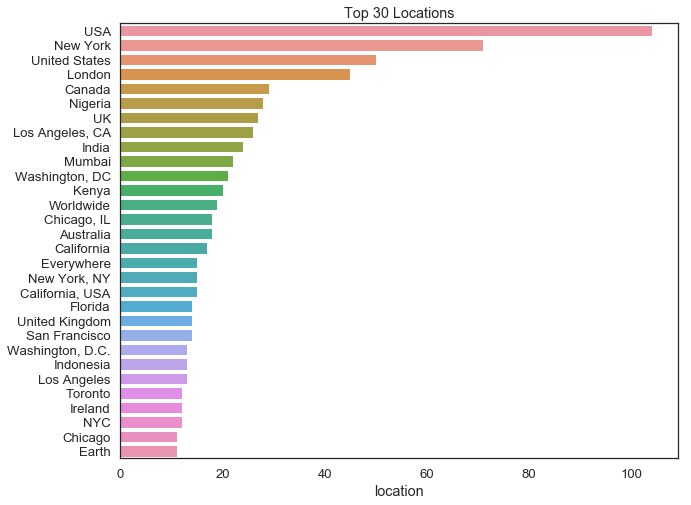

In [34]:
locations_vc = train["location"].value_counts()
sns.barplot(y=locations_vc[0:30].index, x=locations_vc[0:30], orient='h')
plt.title("Top 30 Locations")
plt.show()

Overall, there are 3341 unique locations.

In [73]:
len(train["location"].value_counts())

3341

Interestingly, observe that the location histogram does vary based on disaster vs. non-disaster content. For example, Nigeria is the top 3rd location for disaster tweets yet does not appear in the top 30 locations for non-disaster tweets. Similar observations can be made for India and Mumbai.

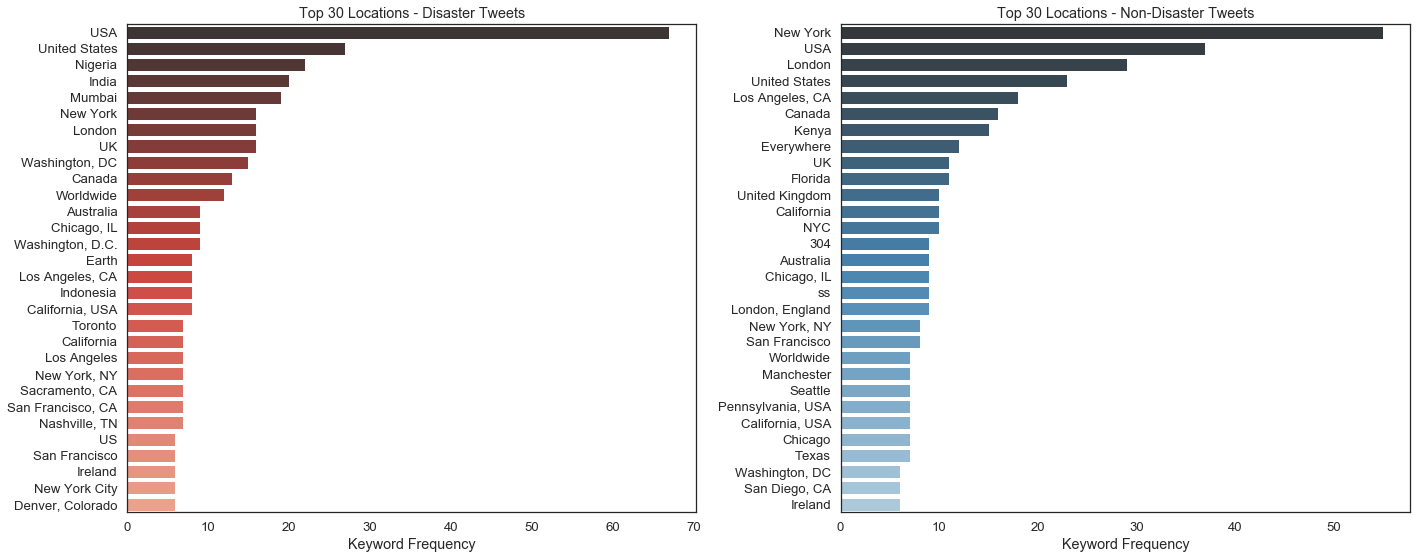

In [74]:
disaster_locations = train.loc[train["target"] == 1]["location"].value_counts()
nondisaster_locations = train.loc[train["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:30].index, x=disaster_locations[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_locations[0:30].index, x=nondisaster_locations[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Locations - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

### Text aka Tweet Content

**Tweet Length**

What is the distribution of tweet length?

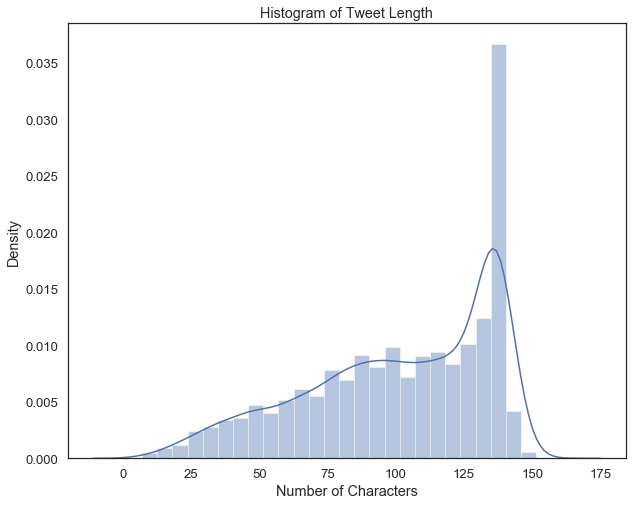

In [76]:
train["tweet_length"] = train["text"].apply(len)
sns.distplot(train["tweet_length"])
plt.title("Histogram of Tweet Length")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

The shortest tweet is 7 characters long; the longest tweet is 157 characters long.

In [77]:
min(train["tweet_length"]), max(train["tweet_length"])

(7, 157)

If we look at the distribution of tweet length for disaster and non-disaster tweets separately, we see that disaster tweets tend to be lengthier.

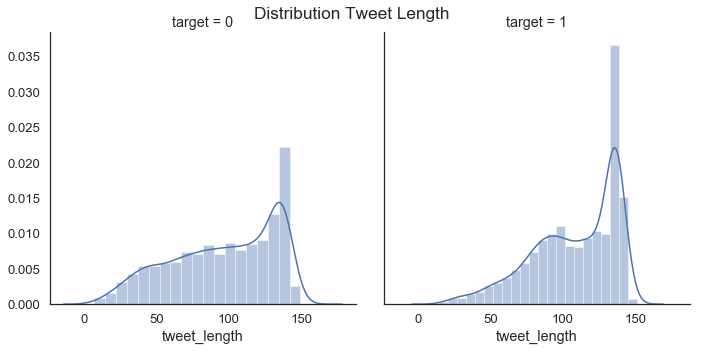

In [102]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "tweet_length")
plt.suptitle("Distribution Tweet Length")
plt.show()

**Number of Words**

Similarly, we can count the number of words in each tweet and examine the distribution.

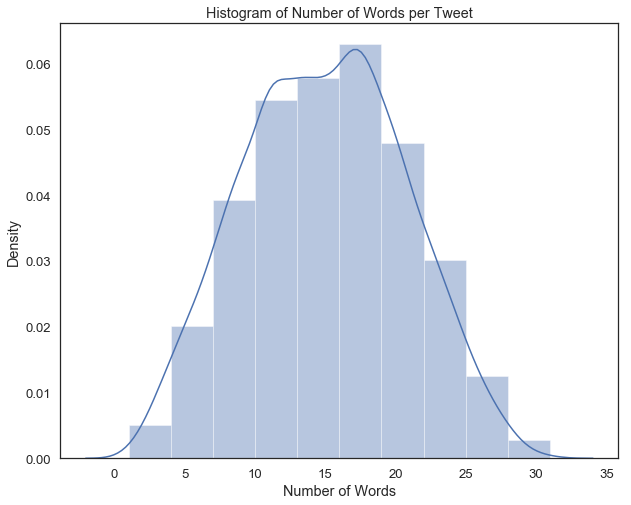

In [119]:
def count_words(x):
    return len(x.split())

train["num_words"] = train["text"].apply(count_words)
sns.distplot(train["num_words"], bins=10)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

However, no strong pattern appears when we create separate histograms for disaster vs. non-disaster tweets.

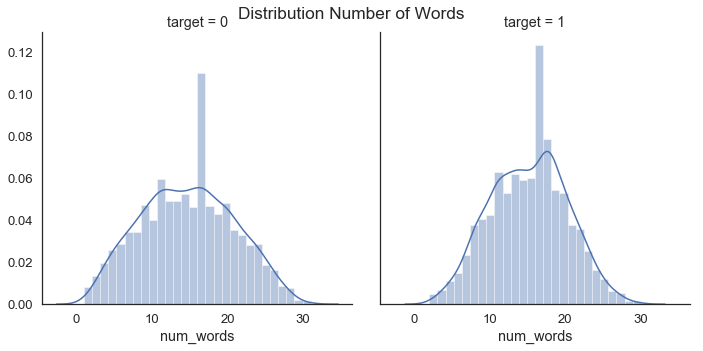

In [103]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "num_words")
plt.suptitle("Distribution Number of Words")
plt.show()

**Average Word Length**

What about average word length?

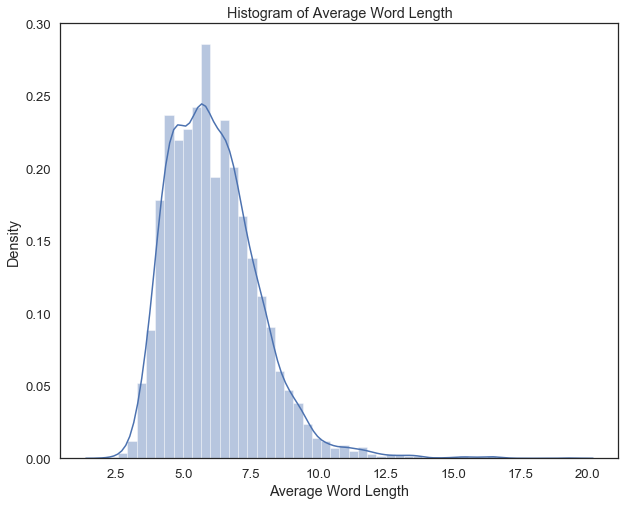

In [120]:
def avg_word_length(x):
    return np.sum([len(w) for w in x.split()]) / len(x.split())

train["avg_word_length"] = train["text"].apply(avg_word_length)
sns.distplot(train["avg_word_length"])
plt.title("Histogram of Average Word Length")
plt.xlabel("Average Word Length")
plt.ylabel("Density")
plt.show()

Again, we see no striking difference between histograms of average word length for disaster vs. non-disaster tweets.

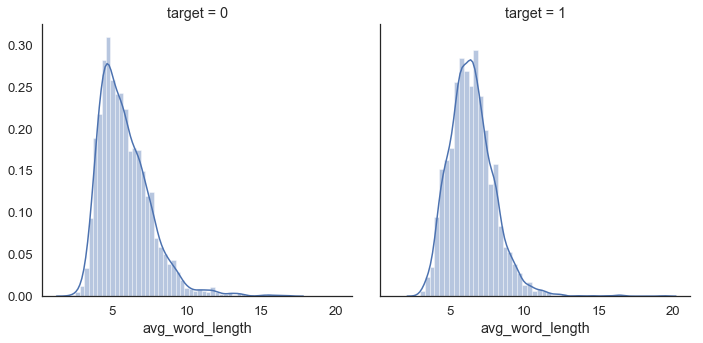

In [118]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "avg_word_length")

**Common Stopwords**

Now, let's see the most common stopwords, i.e. the words that should be ignored. This is not a particularly illuminating exercise, however it is a good refresher for using the NLTK package.

In [228]:
def create_corpus(target):
    corpus = []

    for w in train.loc[train["target"] == target]["text"].str.split():
        for i in w:
            corpus.append(i)
            
    return corpus

def create_corpus_dict(target):
    corpus = create_corpus(target)
            
    stop_dict = defaultdict(int)
    for word in corpus:
        if word in stopwords:
            stop_dict[word] += 1
    return sorted(stop_dict.items(), key=lambda x:x[1], reverse=True)

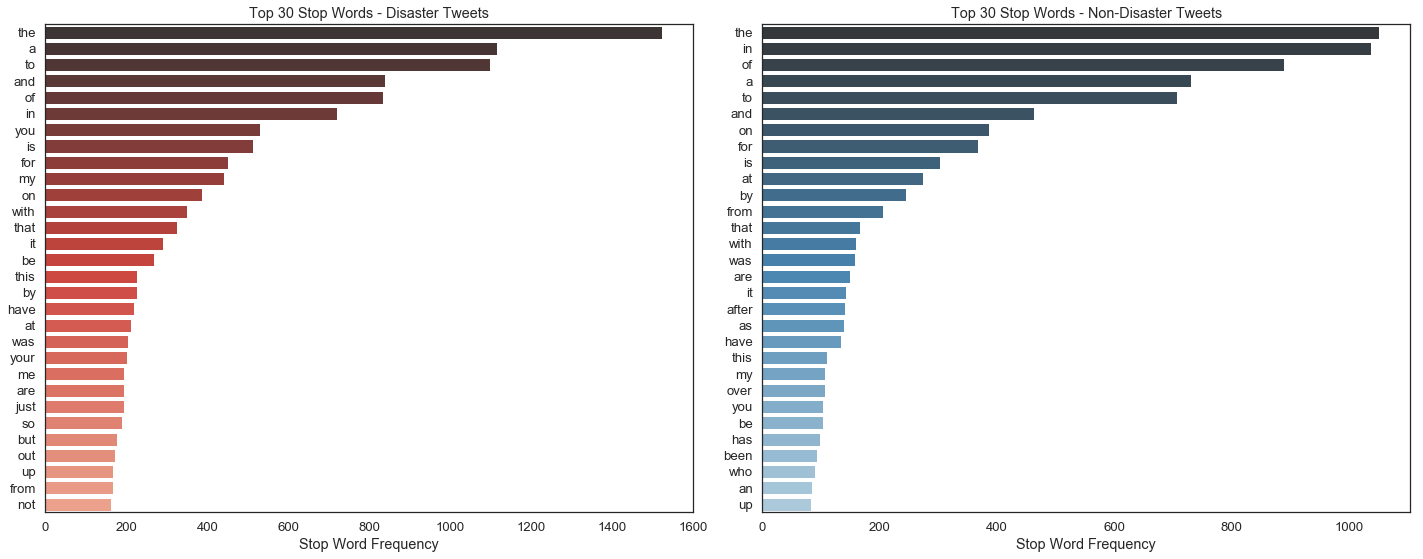

In [257]:
corpus_disaster_dict = create_corpus_dict(0)
corpus_non_disaster_dict = create_corpus_dict(1)

disaster_x, disaster_y = zip(*corpus_disaster_dict)
non_disaster_x, non_disaster_y = zip(*corpus_non_disaster_dict)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=list(disaster_x)[0:30], x=list(disaster_y)[0:30], orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(y=list(non_disaster_x)[0:30], x=list(non_disaster_y)[0:30], orient='h', palette="Blues_d", ax=ax[1]) 
ax[0].set_title("Top 30 Stop Words - Disaster Tweets")
ax[0].set_xlabel("Stop Word Frequency")
ax[1].set_title("Top 30 Stop Words - Non-Disaster Tweets")
ax[1].set_xlabel("Stop Word Frequency")
plt.tight_layout()
plt.show()

**Common Words**

With that out of the way, let's examine the most common non-stopwords.

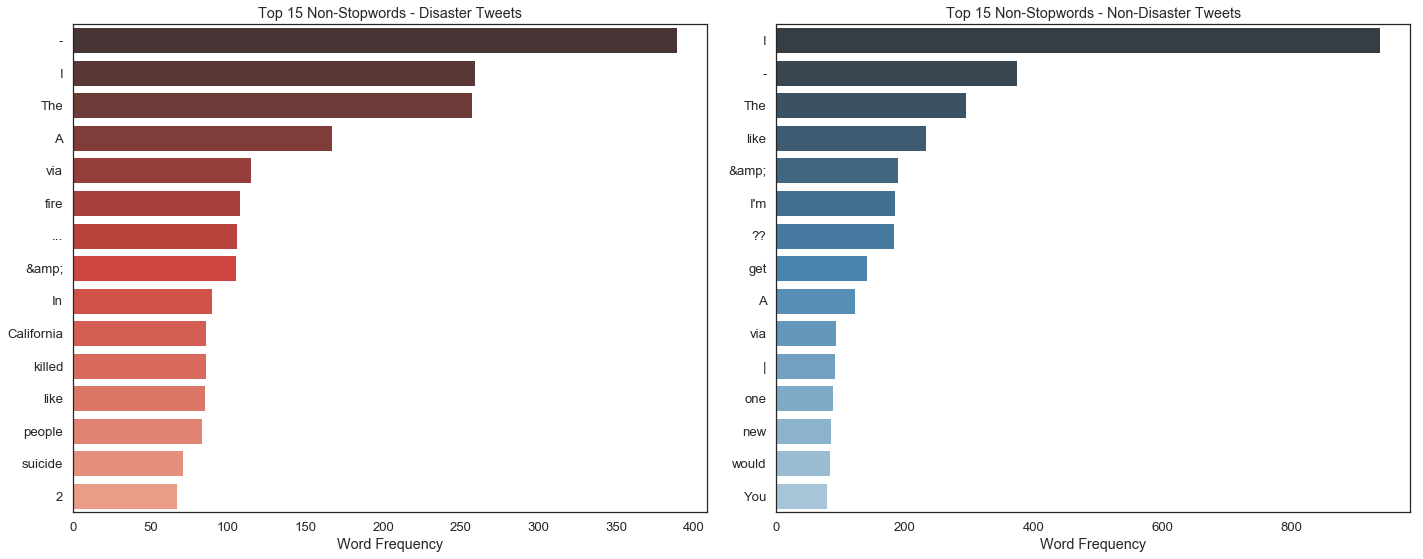

In [268]:
corpus_disaster, corpus_non_disaster = create_corpus(1), create_corpus(0)
counter_disaster, counter_non_disaster = Counter(corpus_disaster), Counter(corpus_non_disaster)
x_disaster, y_disaster, x_non_disaster, y_non_disaster = [], [], [], []

counter = 0
for word, count in counter_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_disaster.append(word)
        y_disaster.append(count)

counter = 0
for word, count in counter_non_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_non_disaster.append(word)
        y_non_disaster.append(count)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=y_disaster, y=x_disaster, orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(x=y_non_disaster, y=x_non_disaster, orient='h', palette="Blues_d", ax=ax[1])
ax[0].set_title("Top 15 Non-Stopwords - Disaster Tweets")
ax[0].set_xlabel("Word Frequency")
ax[1].set_title("Top 15 Non-Stopwords - Non-Disaster Tweets")
ax[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()

**Common Bigrams**

Finally, let's look at the most common bigrams (word pairs).

In [294]:
def bigrams(target):
    corpus = train[train["target"] == target]["text"]
    count_vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = count_vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

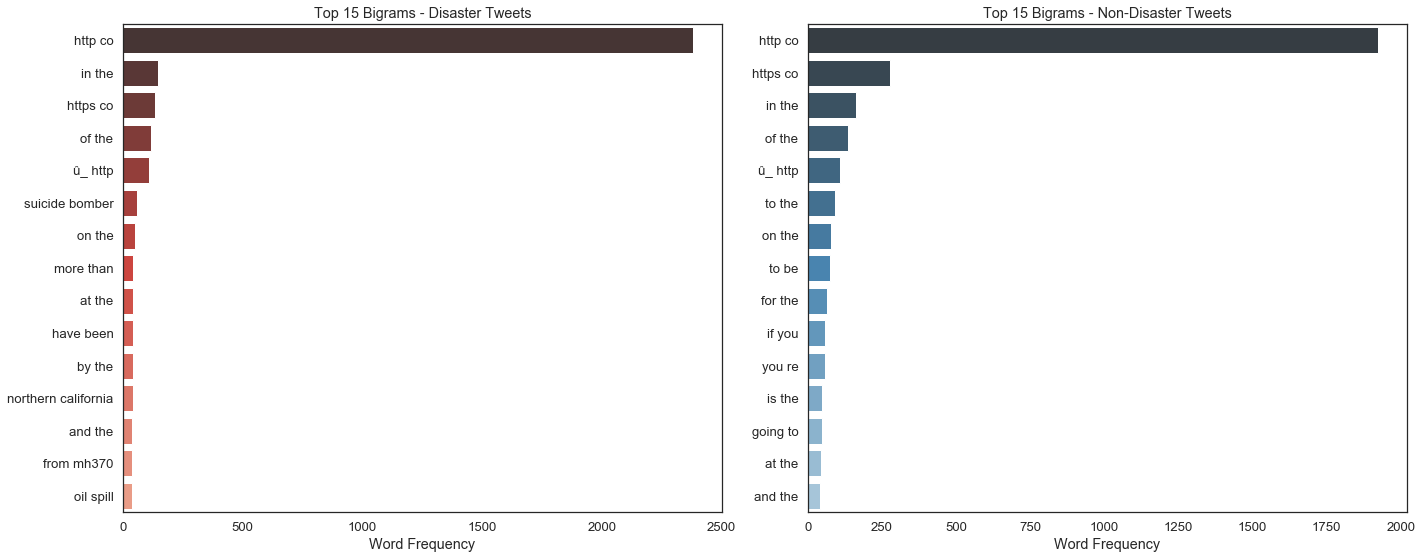

In [300]:
bigrams_disaster = bigrams(1)[:15]
bigrams_non_disaster = bigrams(0)[:15]

x_disaster, y_disaster = map(list, zip(*bigrams_disaster))
x_non_disaster, y_non_disaster = map(list, zip(*bigrams_non_disaster))

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=y_disaster, y=x_disaster, orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(x=y_non_disaster, y=x_non_disaster, orient='h', palette="Blues_d", ax=ax[1])

ax[0].set_title("Top 15 Bigrams - Disaster Tweets")
ax[0].set_xlabel("Word Frequency")
ax[1].set_title("Top 15 Bigrams - Non-Disaster Tweets")
ax[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()

### Target

Do we have approximately equal numbers of true/false targets? More or less. Based on the histogram below, we see that 43% of tweets correspond to real disasters.

Not Disaster: 57.03%, Disaster: 42.97%


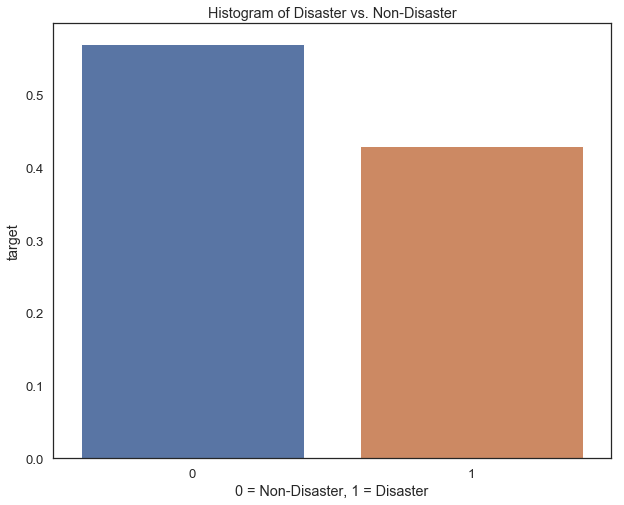

In [66]:
target_vc = train["target"].value_counts(normalize=True)
print("Not Disaster: {:.2%}, Disaster: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster, 1 = Disaster")
plt.show()

### Conclusion

Thanks very much for reading; I hope you enjoyed this exploratory data analysis. If you did, be sure to upvote so you can find this notebook again easily in your Favorites tab.

Suggestions for additional EDA? Please leave a comment below.

Until next time, happy coding :)